In [1]:
import torch
from torch import nn as nn
from torch.nn import functional as F
from torch.autograd import Variable

import numpy as np
from matplotlib import pyplot as plt
from skimage import img_as_float
import mnist
from tqdm import tqdm

from models import FC_RP

In [2]:
y_train, y_test = mnist.train_labels(), mnist.test_labels()
    
X_train = np.array([img_as_float(image).reshape(-1, 1).ravel() for image in mnist.train_images()])
X_test  = np.array([img_as_float(image).reshape(-1, 1).ravel() for image in mnist.test_images()])
    
    
f_in = X_train[0].shape[0]
f_out = 10

In [3]:

model_rp = FC_RP(f_in, 500, 500, f_out, d=500)

In [4]:
def compute_loss_rp(X_batch, y_batch):
    X_batch = Variable(torch.FloatTensor(X_batch))
    y_batch = Variable(torch.LongTensor(y_batch))
    logits = model_rp(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]
        
train_loss = []
val_accuracy = []
loss_history = []
accuracy_history = []

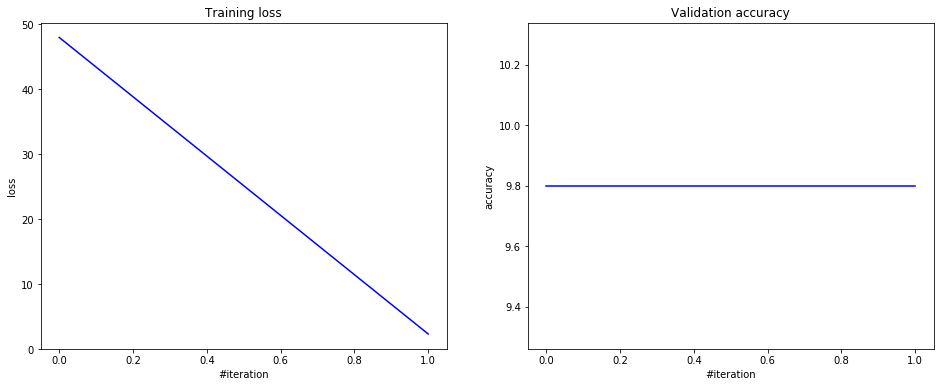

Epoch 2 of 100 took 104.703s
  training loss (in-iteration): 	2.352766
  validation accuracy: 			9.80 %


In [ ]:
import time
from IPython import display

num_epochs = 100 # total amount of full passes over training data
batch_size = 100  # number of samples processed in one SGD iteration

opt = torch.optim.Adam([param for param in model_rp.parameters() if param.requires_grad])

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model_rp.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss_rp(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy()[0])
        
    # And a full pass over the validation data:
    model_rp.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_test, y_test, batch_size):
        logits = model_rp(Variable(torch.FloatTensor(X_batch)))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))\

    loss_history.append(np.mean(train_loss[-len(X_train) // batch_size :]))
    accuracy_history.append(np.mean(val_accuracy[-len(X_test) // batch_size :]) * 100)
    
    # Then we print the results for this epoch:
    display.clear_output(wait=True)
    fig, sp = plt.subplots(1, 2, figsize=(16, 6))
    sp[0].set_title("Training loss")
    sp[0].set_xlabel("#iteration")
    sp[0].set_ylabel("loss")
    sp[0].plot(loss_history, 'b')
    
    sp[1].set_title("Validation accuracy")
    sp[1].set_xlabel("#iteration")
    sp[1].set_ylabel("accuracy")
    sp[1].plot(accuracy_history, 'b')
    
    plt.show()
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_train) // batch_size :]) * 100))